## Download the file and load the dataset

In [ ]:
import gdown

!gdown 1v36q7Efz0mprjAv4g6TkQM2YlDKdqOuy

Downloading...
From: https://drive.google.com/uc?id=1v36q7Efz0mprjAv4g6TkQM2YlDKdqOuy
To: /content/IMDB-Dataset.csv
100% 66.2M/66.2M [00:01<00:00, 55.2MB/s]


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv('./IMDB-Dataset.csv')

# Remove duplicate rows
df = df.drop_duplicates()

## Clean the data by:
1. Removing html tags
2. Removing punctuations
3. Removing numbers
4. Removing icons


In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
!pip install contractions
import contractions

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Set of stopwords for English
stop = set(stopwords.words('english'))

# Expanding contractions
def expand_contractions(text):
    return contractions.fix(text)

# Function to clean and preprocess the text
def preprocess_text(text):
    wl = WordNetLemmatizer()

    # Remove HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    # Expand contractions
    text = expand_contractions(text)

    # Remove emojis
    emoji_clean = re.compile("["
                             u"\U0001F600-\U0001F64F"
                             u"\U0001F300-\U0001F5FF"
                             u"\U0001F680-\U0001F6FF"
                             u"\U0001F1E0-\U0001F1FF"
                             u"\U00002702-\U000027B0"
                             u"\U000024C2-\U0001F251"
                             "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'', text)

    # Add space after full stop
    text = re.sub(r'\.(?=\S)', '. ', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove punctuation and make text lowercase
    text = "".join([char.lower() for char in text if char not in string.punctuation])

    # Lemmatize the text and remove stopwords
    text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()])

    return text

# Apply the preprocess_text function to the 'review' column in the dataframe
df['review'] = df['review'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-5-576b4c2d145a>:26: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


## Analyzing data in the dataset

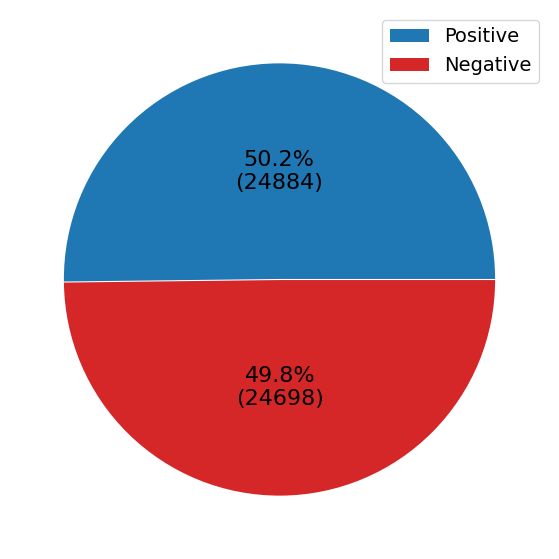

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to format the autopct argument in the pie chart
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Calculate frequencies of positive and negative sentiments
freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

# Data and labels for the pie chart
data = [freq_pos, freq_neg]
labels = ['positive', 'negative']

# Create the pie chart
fig, ax = plt.subplots(figsize=[11, 7])
plt.pie(
    x=data,
    autopct=lambda pct: func(pct, data),
    explode=[0.0025] * 2,
    pctdistance=0.5,
    colors=[sns.color_palette()[0], 'tab:red'],
    textprops={'fontsize': 16}
)

# Add legend and save the chart as a PNG file
plt.legend(labels=['Positive', 'Negative'], loc="best", prop={'size': 14})
fig.savefig("PieChart.png")

# Show the pie chart
plt.show()


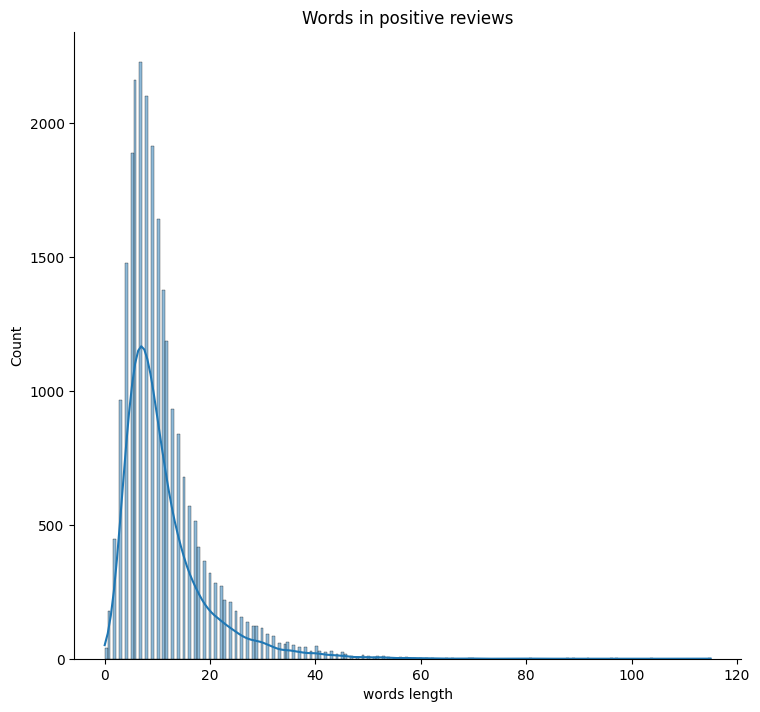

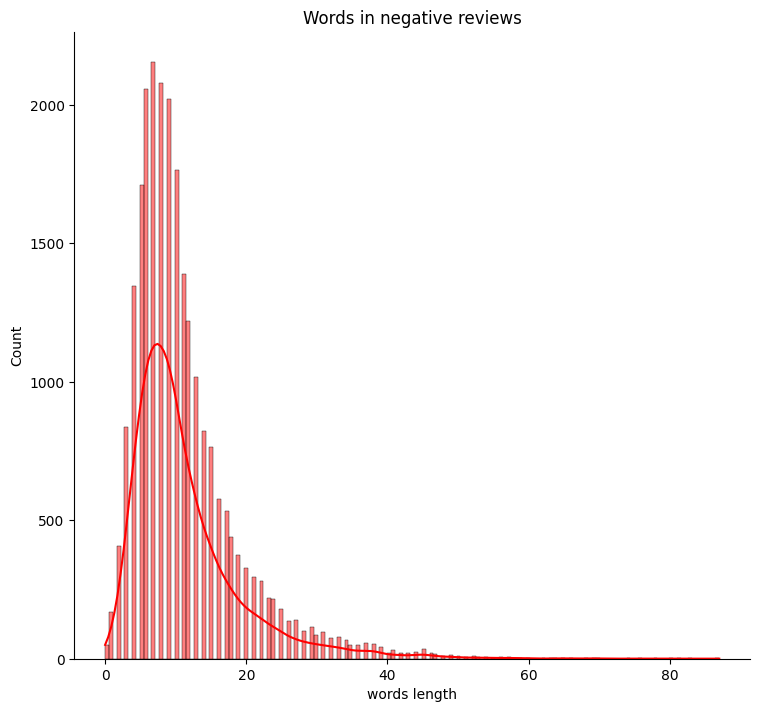

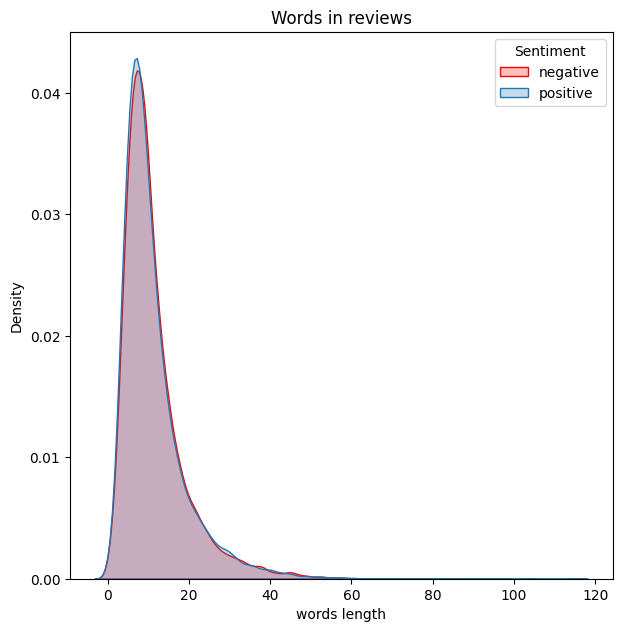

In [ ]:
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = words_len

# Displot for positive sentiment
hist_positive = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x="words length", hue="sentiment", kde=True, height=7, aspect=1.1, legend=False
).set(title='Words in positive reviews')
plt.show()

# Displot for negative sentiment
hist_negative = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'],
    x="words length", hue="sentiment", kde=True, height=7, aspect=1.1, legend=False, palette=['red']
).set(title='Words in negative reviews')
plt.show()

# Kernel density plot for both sentiments
plt.figure(figsize=(7, 7.1))
kernel_distribution_number_words_plot = sns.kdeplot(
    data=df_temp, x="words length", hue="sentiment", fill=True, palette=[sns.color_palette()[0], 'red']
).set(title='Words in reviews')

plt.legend(title='Sentiment', labels=['negative', 'positive'])
plt.show()


## Split and train the dataset

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Label encode the target variable (sentiment)
label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df['sentiment'])

# Assign the 'review' column from the DataFrame to x_data
x_data = df['review']

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

## Vectorize the text

In [ ]:
# Initialize the TfidfVectorizer with a maximum of 10,000 features
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# Fit the vectorizer on the training data (no need to fit with y_train)
tfidf_vectorizer.fit(x_train)

# Transform the training and test data using the fitted vectorizer
x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

## Train and evaluate the model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the DecisionTreeClassifier with 'entropy' criterion and random state for reproducibility
dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

# Fit the model on the training data
dt_classifier.fit(x_train_encoded, y_train)

# Predict on the test data
y_pred = dt_classifier.predict(x_test_encoded)

# Calculate and display the accuracy score
accuracy2 = accuracy_score(y_pred, y_test)
accuracy2

0.56539275990723

In [ ]:
# Using RandomForestClassifier
# Initialize the RandomForestClassifier with a random state for reproducibility
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_classifier.fit(x_train_encoded, y_train)

# Predict on the test data
y_pred = rf_classifier.predict(x_test_encoded)

# Calculate and display the accuracy score
accuracy = accuracy_score(y_pred, y_test)
accuracy

0.5670061510537461